In [1]:
import pandas as pd
import numpy as np

from IPython.display import display, Markdown

from urllib.request import urlopen
import requests

from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt

import re
import nltk
from bs4 import BeautifulSoup
from pymorphy2 import MorphAnalyzer
from wordcloud import WordCloud

import json

from pathlib import Path
import os

from ngutils import *

from tqdm import tqdm

DATA_DIR = Path('data')
os.listdir(DATA_DIR)

['areas + districts.json',
 'areas.csv',
 'datasets.json',
 'dataset_news_1.xlsx',
 'dataset_news_1_mod.xlsx',
 'dst-off-lct10.py',
 'news.jsn',
 'normal_forms.csv',
 'organizations.csv',
 'result_task3.csv',
 'Материалы для презентации ЛЦТ21',
 'Материалы для презентации ЛЦТ21-20211018T195925Z-001.zip',
 'ТЗ_Задача 10. Рекомендательная система новостей для пользователей mos.ru и приложения Моя Москва.pdf',
 'Шаблон презентации конкурса Лидеры Цифровой трансформации 2021.pptx']

Финальный этап (4-7 ноября):

Члены комиссии по присуждению премий Мэра Москвы «Лидеры цифровой трансформации» голосуют по шкале от 0 до 5 баллов с шагом 1 балл согласно следующим критериям:

* Подход коллектива к решению задачи (идея решения задачи, оригинальность, способ реализации);

* Техническая проработка решения (обоснованность выбранных методов для разработки модели, алгоритма, сервиса);

* Эффективность решения в рамках поставленной задачи (точность прогнозирования/распознавания/рекомендаций, количество учтенных факторов и др. в зависимости от выбранной задачи);

* Выступление коллектива на питч-сессии.

In [2]:
# Загрузка организаций. Источник - mos.ru/api, выявлен путем изучения сайта mos.ru
if not (DATA_DIR/'organizations.csv').exists():
    list_organizations = []
    href = 'https://www.mos.ru/api/structure/v1/frontend/json/ru/institutions?per-page=50'
    while True:
        json_page = json.load(urlopen(href))
        list_organizations += json_page['items']
        print(f"Загружено {len(list_organizations)} организаций"+" "*10, end='\r')
        if href != json_page['_links']['last']['href']:
            href = json_page['_links']['next']['href']
        else:
            break
    # Список организаций/департаменов сохраняем в таблицу df_organizations
    df_organizations = (
        pd.DataFrame(list_organizations)
        .drop(columns=['yandex_metrika_id','edo_id','rich_snippet','external_card_title','reception_description','icon'])
        .set_index('id')
    )
    df_organizations.lead_institution_id = df_organizations.lead_institution_id.fillna(0).astype(int)
    df_organizations.to_csv(DATA_DIR/'organizations.csv')
else:
    df_organizations = pd.read_csv(DATA_DIR/'organizations.csv', index_col='id')

view_types(df_organizations, display_force=True)
df_organizations.head(3)

int   str   NaN  \
type_id              2905     0     0   
name                    0  2905     0   
description             0    57  2848   
pgu_link                0    30  2875   
has_reception        2905     0     0   
code                    0    51  2854   
short_name              0   238  2667   
lead_institution_id  2905     0     0   
external_card_url       0   160  2745   

                                                                 (min)  \
type_id                                                           1691   
name                       Aкционерное общество "Концерн "Радио-центр"   
description          Антитеррористическая комиссия города Москвы ко...   
pgu_link                      /pgu/ru/departments/7700000000163323287/   
has_reception                                                        0   
code                                                               apr   
short_name                                                  АНО "ЦРСВ"   
lead_institution_id                                                  0   
external_card_url                             http://adm-moskovsky.ru/   

                                                                 (max)  \
type_id                                                          14691   
name                 Юридическое управление префектуры Северо-Восто...   
description          Управление делами Мэра и Правительства Москвы ...   
pgu_link             https://www.mos.ru/pgu/ru/departments/77000000...   
has_reception                                                        1   
code                                                              zags   
short_name                                                     Ясенево   
lead_institution_id                                          103564090   
external_card_url                           https://zyablikovo.mos.ru/   

                     (unique)  
type_id                    13  
name                     2842  
description                58  
pgu_link                   31  
has_reception               2  
code                       52  
short_name                239  
lead_institution_id       127  
external_card_url         161

2905 rows x 9 columns


type_id                                               name  \
id                                                                    
9224090     6691  Комитет города Москвы по обеспечению реализаци...   
9238090     1691  Департамент предпринимательства и инновационно...   
9463090     1691  Департамент внешнеэкономических и международны...   

                                               description  \
id                                                           
9224090  Москомстройинвест контролирует соблюдение зако...   
9238090  Основными направлениями работы Департамента яв...   
9463090  Департамент разрабатывает и реализует политику...   

                                                  pgu_link  has_reception  \
id                                                                          
9224090  https://www.mos.ru/pgu/ru/departments/77000000...              1   
9238090                                                NaN              1   
9463090                                                NaN              1   

           code         short_name  lead_institution_id external_card_url  
id                                                                         
9224090  invest  Москомстройинвест             11491090               NaN  
9238090    dpir               ДПИР             11491090               NaN  
9463090    dvms               ДВМС             11491090               NaN

In [3]:
# Загрузка округов и районов. Источник - mos.ru/api, ссылка извлечена из файла 'areas + districts.json', 
# предоставленного организаторами
if not (DATA_DIR/'areas.csv').exists():
    href = 'https://www.mos.ru/api/directories/v2/frontend/json/territory/districts?expand=areas&per-page=50&page=1'
    json_page = json.load(urlopen(href))
    s_areas_districts = pd.DataFrame(json_page['items']).set_index(['id', 'title']).areas
    df_areas = (
        s_areas_districts[s_areas_districts.str.len()>0]
        .explode()
        .transform({'area_id': lambda x:x['id'], 'area_title': lambda x:x['title']})
        .reset_index()
        .set_index('area_id')
        .rename(columns={'id': 'district_id', 'title': 'district_title'})
    )
    df_areas.to_csv(DATA_DIR/'areas.csv')
else:
    df_areas = pd.read_csv(DATA_DIR/'areas.csv', index_col='area_id')
    
districts = dict(df_areas[['district_id', 'district_title']].values)
view_types(df_areas, display_force=True)
print(f"\nОкруга: \n{districts}")
df_areas.sample(3)

int  str          (min)    (max)  (unique)
district_id     146    0           1500    11500        11
district_title    0  146      Восточный    Южный        11
area_title        0  146  Академический  Ясенево       146

146 rows x 3 columns

Округа: 
{1500: 'Центральный', 2500: 'Южный', 3500: 'Северный', 4500: 'Юго-Западный', 5500: 'Северо-Восточный', 6500: 'Западный', 7500: 'Восточный', 8500: 'Северо-Западный', 9500: 'Юго-Восточный', 10500: 'Зеленоградский', 11500: 'Троицкий и Новомосковский'}


district_id district_title            area_title
area_id                                                  
34501           3500       Северный     Западное Дегунино
87501           7500      Восточный             Восточный
79501           6500       Западный  Проспект Вернадского

In [4]:
print(f"Округ id = 1500: {districts[1500]}")
print(f"Район id = 16501: {df_areas.loc[16501].area_title}; "
      f"округ id = {df_areas.loc[16501].district_id}: {df_areas.loc[16501].district_title}")

Округ id = 1500: Центральный
Район id = 16501: Зябликово; округ id = 2500: Южный


In [5]:
# Загрузка новостей
df_json = pd.read_json(DATA_DIR/'news.jsn')

In [6]:
# Переформатирование таблицы новостей
df_json['tag_ids'] = df_json.tags.apply(lambda x:[item['id'] for item in x])

# Тэги
df_tags = pd.DataFrame(chain.from_iterable(df_json.tags)).drop_duplicates().set_index('id').rename_axis(None)
df_tags['qty'] = pd.Series(Counter(chain.from_iterable(df_json.tag_ids)))
print('Топ-10 тэгов')
df_tags = df_tags.sort_values('qty', ascending=False)
df_tags.head(10)

Топ-10 тэгов


title           created_at  qty
4019217        Сергей Собянин  2016-01-26 13:27:14  744
36217           строительство  2015-12-28 00:16:28  414
47247217          коронавирус  2020-03-03 12:40:22  343
62217                   парки  2015-12-28 00:16:28  310
25217         благоустройство  2015-12-28 00:16:28  294
5433217       Владимир Ефимов  2016-04-18 12:11:11  266
3217                транспорт  2015-12-28 00:16:28  258
47576217             COVID-19  2020-03-16 11:46:31  221
16312217  программа реновации  2017-03-23 16:26:46  200
19925217       Алексей Фурсин  2017-07-19 17:50:16  188

In [7]:
# Темы
df_themes = pd.DataFrame(chain.from_iterable(df_json.themes)).drop_duplicates().set_index('id').rename_axis(None)
df_themes['qty'] = pd.Series(Counter(chain.from_iterable(df_json.theme_ids)))
print('Топ-10 тем')
df_themes = df_themes.sort_values('qty', ascending=False)
df_themes.head(10)

Топ-10 тем


title           created_at  \
157287  Строительство и благоустройство  2019-11-06 11:08:33   
115287                Интересная Москва  2019-01-15 12:02:21   
27287                    Развитие метро  2017-11-03 22:23:24   
2287                 Планируйте маршрут  2017-11-03 22:23:24   
99287                  Музейные истории  2018-06-07 15:19:55   
213287            Здоровье и технологии  2021-05-19 12:06:26   
117287                Семейные выходные  2019-04-08 13:04:35   
116287              Советы библиотекаря  2019-03-18 12:23:01   
60287                       Люди города  2017-11-03 22:23:24   
210287                        Капремонт  2021-03-12 14:09:52   

                 updated_at  icon_id                      url  qty  
157287  2021-07-02 17:43:19   4061.0  /news/maintheme/157287/  348  
115287  2021-07-06 20:04:25   8061.0  /news/maintheme/115287/  237  
27287   2021-07-02 17:47:10   3061.0   /news/maintheme/27287/   99  
2287    2021-07-07 10:17:22      NaN    /news/maintheme/2287/   80  
99287   2021-07-06 20:04:25   5061.0   /news/maintheme/99287/   77  
213287  2021-07-02 17:49:57  19061.0  /news/maintheme/213287/   63  
117287  2021-07-02 16:09:06  11061.0  /news/maintheme/117287/   48  
116287  2021-07-02 16:09:06      NaN  /news/maintheme/116287/   43  
60287   2021-04-08 20:36:38      NaN   /news/maintheme/60287/   39  
210287  2021-06-18 18:29:01      NaN  /news/maintheme/210287/   37

In [8]:
# Сферы
df_json['sphere_id'] = df_json.sphere.apply(lambda x:x['id'])
df_json['sphere_ids'] = df_json.spheres.apply(lambda x:[item['id'] for item in x])
df_spheres = pd.DataFrame(chain.from_iterable(df_json.spheres)).drop_duplicates().set_index('id').rename_axis(None)
df_spheres['qty'] = pd.Series(Counter(chain.from_iterable(df_json.sphere_ids)))
print('Топ-10 сфер')
df_spheres = df_spheres.sort_values('qty', ascending=False)
df_spheres.head(10)

Топ-10 сфер


title  special  activated  priority   qty
231299                        Мой район        0          1       410  1416
4299      Строительство и реконструкция        0          1       490  1095
3299                           Культура        0          1       360   986
12299   Экономика и предпринимательство        0          1       370   847
1299                   Социальная сфера        0          1       400   717
5299                Городское хозяйство        0          1       460   651
18299                   Здравоохранение        0          1       500   606
183299                       Технологии        0          1       440   602
2299                          Транспорт        0          1       480   593
15299                       Образование        0          1       470   455

In [9]:
# Организации
df_json['void'] = ''
df_json.void = df_json.void.str.split()
df_json.organizations.mask(df_json.organizations.isna(), df_json.void, inplace=True)
df_json['organization_ids'] = df_json.organizations
df_organizations['qty'] = pd.Series(Counter(chain.from_iterable(df_json.organization_ids)))
print('Топ-10 организаций')
df_organizations = df_organizations.sort_values('qty', ascending=False)[
    ['name', 'has_reception', 'code','short_name','lead_institution_id', 'qty']
]
df_organizations.head(10)

Топ-10 организаций


name  has_reception  \
id                                                                            
20614090   Департамент информационных технологий города М...              1   
9238090    Департамент предпринимательства и инновационно...              1   
19180090   Департамент градостроительной политики города ...              1   
19889090   Департамент жилищно-коммунального хозяйства го...              1   
12585090                  Департамент культуры города Москвы              1   
20488090      Департамент культурного наследия города Москвы              1   
103367090  Департамент инвестиционной и промышленной поли...              1   
20882090   Департамент транспорта и развития дорожно-тран...              1   
20703090   Департамент природопользования и охраны окружа...              1   
9479090            Департамент здравоохранения города Москвы              1   

              code short_name  lead_institution_id    qty  
id                                                         
20614090       dit        ДИТ             11491090  319.0  
9238090       dpir       ДПИР             11491090  309.0  
19180090       dgp        ДГП             11491090  190.0  
19889090      dgkh       ДЖКХ             11491090  187.0  
12585090   kultura   Депкульт             11491090  186.0  
20488090       dkn        ДКН             11491090  159.0  
103367090     dipp       ДИПП             11491090  157.0  
20882090        dt   Дептранс             11491090  153.0  
20703090       eco     ДПиООС             11491090  146.0  
9479090     dzdrav   Депздрав             11491090  143.0

In [10]:
# Заполняем пропуски превью и текста, подставляя замещающие столбцы
df_json.preview_text.mask(df_json.preview_text.isna(), df_json.preview, inplace=True)
df_json.full_text.mask(df_json.full_text.isna(), df_json.text, inplace=True)

df_json.theme_id = df_json.theme_id.fillna(0).astype(int)
df_json.territory_area_id = df_json.territory_area_id.fillna(0).astype(int)
df_json.territory_district_id = df_json.territory_district_id.fillna(0).astype(int)
df_json.oiv_id = df_json.oiv_id.fillna(0).astype(int)
df_json.label = df_json.label.fillna('')

In [11]:
# Оставляем только нужные колонки
cols = ['id', 'title', 'url', 'published_at', 
        'label', 'tag_ids', 
        'theme_id', 'theme_ids', 
        'sphere_id', 'sphere_ids', 
        'territory_area_id', 'territory_district_id', 
        'preview_text', 'full_text', 
        'oiv_id', 'organization_ids']

In [12]:
df_news = df_json[cols].set_index('id')
view_types(df_news)

str  Timestamp  list   int  \
title                  6554          0     0     0   
url                    6554          0     0     0   
published_at              0       6554     0     0   
label                  6554          0     0     0   
tag_ids                   0          0  6554     0   
theme_id                  0          0     0  6554   
theme_ids                 0          0  6554     0   
sphere_id                 0          0     0  6554   
sphere_ids                0          0  6554     0   
territory_area_id         0          0     0  6554   
territory_district_id     0          0     0  6554   
preview_text           6554          0     0     0   
full_text              6554          0     0     0   
oiv_id                    0          0     0  6554   
organization_ids          0          0  6554     0   

                                                                   (min)  \
title                  #Доброосень: на фестивале «Золотая осень» стар...   
url                                         /mayor/themes/10299/3239050/   
published_at                                         2011-08-29 19:42:00   
label                                                                      
tag_ids                         [10004217, 13858217, 33662217, 44745217]   
theme_id                                                               0   
theme_ids                               [100287, 115287, 116287, 117287]   
sphere_id                                                           1299   
sphere_ids                                                          1299   
territory_area_id                                                      0   
territory_district_id                                                  0   
preview_text                                                               
full_text              <blockquote>&laquo;ВДНХ меняется на глазах. Еж...   
oiv_id                                                                 0   
organization_ids                                             [100173090]   

                                                                   (max)  \
title                  ​Советская классика на больших экранах: «Моски...   
url                                                  /news/item/9921073/   
published_at                                         2021-08-31 18:47:56   
label                                                      Юбилей фильма   
tag_ids                                                               []   
theme_id                                                          213287   
theme_ids                                                             []   
sphere_id                                                         352299   
sphere_ids                                                        352299   
territory_area_id                                                 146501   
territory_district_id                                              12500   
preview_text           Ярмарки нового формата становятся площадками д...   
full_text              Мэр Москвы принял участие в&nbsp;торжественной...   
oiv_id                                                         103466090   
organization_ids                                                      []   

                       (unique)  
title                      6485  
url                        6554  
published_at               6453  
label                        57  
tag_ids                    6099  
theme_id                     41  
theme_ids                    77  
sphere_id                    62  
sphere_ids                 1408  
territory_area_id           146  
territory_district_id        13  
preview_text               6425  
full_text                  6554  
oiv_id                       45  
organization_ids            161

6554 rows x 15 columns


In [13]:
morph = MorphAnalyzer()
stop = nltk.corpus.stopwords.words('russian')
stop.extend(['как', 'что', 'где', 'какой', 'для', 'более', 'чем', 'ещё', 'быть', 'стать', 'мой', 'это', 'можно', 'всё', 
             'почти', 'парка', 'после', 'первый', 'четыре', 'пять', 'шесть', 'семь', 'тысяча', 'самый', 'конец', 'год', 
             'который', 'также', 'весь','свой', 'сергей', 'число', 'около', 'имя', 'кроме', 'каждый', 'корп', 'москва',
            ])
str(stop)
# стоп-слова с добавлениями

"['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'вп

In [14]:
# Загрузка словаря нормальных форм слов для ускорения работы
if (DATA_DIR/'normal_forms.csv').exists():
    dict_nf = dict(pd.read_csv(DATA_DIR/'normal_forms.csv', index_col=0, squeeze=True))
else:
    dict_nf = dict()

# Функция для преобразование html-кода в текст. Текст пришлось дополнительно чистить от блоков ссылок
bt = lambda x:BeautifulSoup(re.sub(r'<p class="mceNonEditable inline_question_history">.*?<\/p>', '', x)).get_text()

# Функция для получения нормальной формы списка слов с буферным словарем для ускорения работы
text_normalize = lambda x: list(
    dict_nf[word] if word in dict_nf
    else dict_nf.setdefault(word, morph.normal_forms(word)[0].upper())
    for word in x
)

# Функция для удаления стоп-слов
del_stop = lambda x: [word for word in x if word.lower() not in stop]

In [15]:
# Основная функция лемматизации и нормализации корпуса - создаем BOW (bag of words)
def text_to_BOW(text_input):
    return del_stop(text_normalize(re.findall(r'\b(?<!-)[а-я][а-я-]+[а-я](?!-)\b', bt(text_input).lower())))

# Формирование списков нормализованных слов для заголовка и текста каждой новости
df_news['words_title'] = df_news.title.apply(text_to_BOW)
df_news['words_text']  = df_news.full_text.apply(text_to_BOW)

# Сохраняем словарь нормальных форм слов
pd.Series(dict_nf).to_csv(DATA_DIR/'normal_forms.csv')

In [16]:
# 100 самых часто-встречающихся слов в корпусе за август
w = pd.Series(chain.from_iterable(df_news.words_text))
w.str.lower().value_counts().head(100).index

Index(['дом', 'работа', 'новый', 'город', 'проект', 'московский', 'центр',
       'время', 'улица', 'человек', 'мочь', 'программа', 'станция',
       'городской', 'место', 'столица', 'здание', 'получить', 'территория',
       'объект', 'день', 'большой', 'работать', 'ребёнок', 'школа', 'площадка',
       'развитие', 'процент', 'рассказать', 'департамент', 'помощь', 'район',
       'строительство', 'площадь', 'система', 'метр', 'участник', 'специалист',
       'житель', 'детский', 'миллион', 'пройти', 'появиться', 'парк',
       'участок', 'москвич', 'россия', 'услуга', 'социальный', 'музей',
       'сделать', 'столичный', 'комплекс', 'создать', 'современный', 'рубль',
       'линия', 'организация', 'электронный', 'отметить', 'общий', 'часть',
       'построить', 'участие', 'медицинский', 'смочь', 'сервис', 'метро',
       'мэр', 'вид', 'вопрос', 'возможность', 'хороший', 'начало',
       'находиться', 'технология', 'мероприятие', 'принять', 'портал', 'жизнь',
       'руководитель', 'ве

In [17]:
# Функции для рисования качества словарного корпуса
# Очень впечатляет и сразу дает представление об объекте. Размер слов имеет значение!
def pic_profile(words, random_state=10):
    wordcloud = WordCloud(width=800, height=400, background_color="white", random_state=random_state).generate(
        ' '.join(pd.Series(words).sample(frac=1)))
    plt.figure(figsize=(18, 18))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
def ava_profile(words, random_state=None):
    wordcloud = WordCloud(width=240, height=120, background_color="white", random_state=random_state).generate(
        ' '.join(pd.Series(words).sample(frac=1)))
    return wordcloud

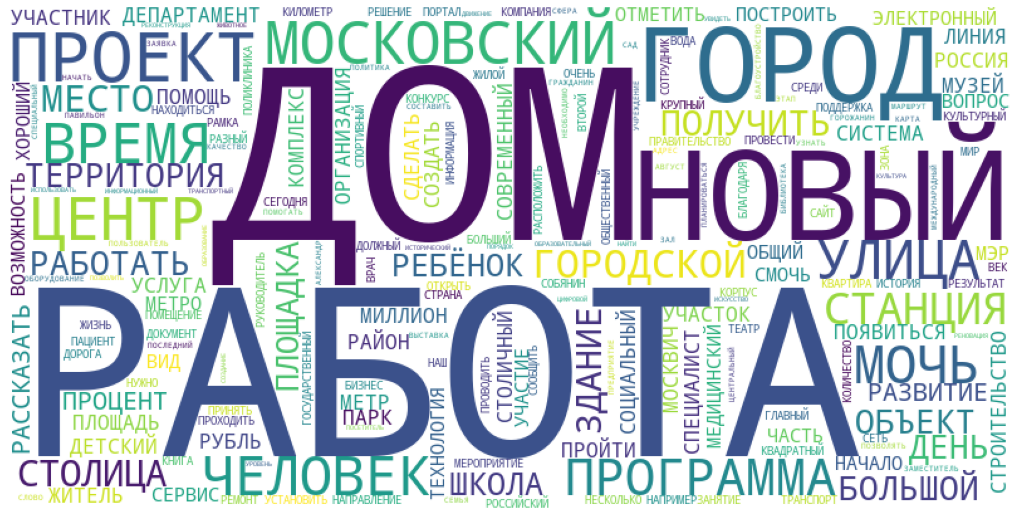

In [18]:
pic_profile(w)

# Полный профиль всего новостного корпуса за август 2021

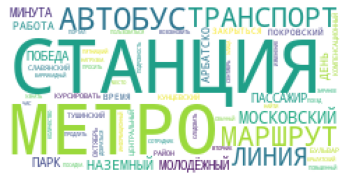

In [19]:
plt.imshow(ava_profile(chain.from_iterable(df_news.words_text.iloc[1:2])))
plt.axis("off")
plt.show()

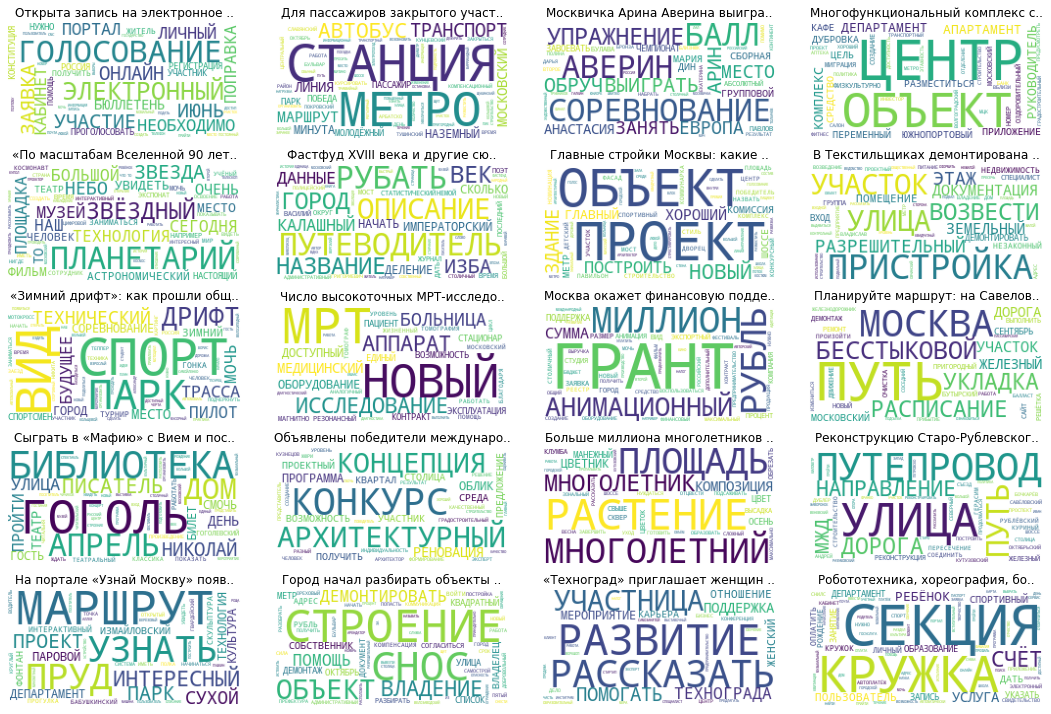

In [20]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax, title, words_text in zip(axs.flat, df_news.title.iloc[:20], df_news.words_text.iloc[:20]):
    ax.imshow(ava_profile(words_text))
    ax.axis("off")
    ax.set_title(title[:30]+'..')

plt.tight_layout()
plt.show()

# Новости. Картина дня, например

In [21]:
# Функция для расчета idf для всех слов корпуса, inverse document frequency — обратная частота документа
def calc_idf(corpus):
    return (np.log10(len(corpus))
            -np.log10(pd.Series(corpus).explode().reset_index().drop_duplicates().iloc[:,1].value_counts()))

# Функция для расчета tf для всех слов текста документа, term frequency — частота слова
def calc_tf(text):
    return pd.Series(Counter(text))/len(text)

# Функция для расчета dw для всех документов, document weight — удельный вес документа в корпусе
def calc_dw(corpus):
    return pd.Series(corpus).str.len()/len(corpus)

In [22]:
# Пример calc_idf
calc_idf(df_news.words_text)

НОВЫЙ                 0.245963
ГОРОД                 0.246197
РАБОТА                0.251722
ВРЕМЯ                 0.287718
МОСКОВСКИЙ            0.333347
                        ...   
КУЗНЯ                 3.816506
НЕМОЧНЫЙ              3.816506
СИРЫЙ                 3.816506
МУЗШКОЛА              3.816506
БЛАГОПРИЯТСТВОВАТЬ    3.816506
Name: words_text, Length: 54215, dtype: float64

In [23]:
# Пример calc_tf
calc_tf(df_news.words_text.iloc[0]).nlargest()

ГОЛОСОВАНИЕ    0.043393
ЭЛЕКТРОННЫЙ    0.031558
УЧАСТИЕ        0.017751
ЗАЯВКА         0.017751
ИЮНЬ           0.017751
dtype: float64

In [24]:
# Пример calc_dw
calc_dw(df_news.words_text).nlargest()

id
7465050     0.631218
4851050     0.607568
72877073    0.601160
6629050     0.553860
72684073    0.486878
Name: words_text, dtype: float64

In [25]:
# Расчет tf_idf для всех слов во всех документах
tfs = pd.concat([calc_tf(x) for x in tqdm(df_news.words_text)], keys=df_news.words_text.index, names=['id', 'words'])
tf_idfs = tfs.swaplevel(0, 1).mul(calc_idf(df_news.words_text), level='words').sort_index()
tf_idfs

100%|██████████████████████████████████████████████████████████████████████████| 6554/6554 [00:05<00:00, 1285.82it/s]


words         id      
ЁЖ            4174050     0.004932
              15535073    0.016490
              61031073    0.004008
              72007073    0.001808
              84196073    0.004744
                            ...   
ЯЩИК          95258073    0.002354
ЯЩИК-КОРПУС   91851073    0.004322
ЯЩИЧЕК        76852073    0.008774
ЯЩИЧЕК-ДОМИК  95204073    0.004148
ЯЩИЧНЫЙ       76852073    0.008774
Length: 1283315, dtype: float64

In [26]:
# Функция оценки схожести текста с документами корпуса
def score_tdidf(text_BOF, tf_idfs_corpus):
    # если слово в тексте встречается несколько раз, учитываем это, рассчитав мультипликатор
    mult = pd.Series(text_BOF).value_counts()
    return tf_idfs_corpus.loc[mult.index].mul(mult, level='words').groupby(level='id').sum()

In [27]:
text = df_news.words_text.loc[6751050]
str(text[:100])

"['СЕНТЯБРЬ', 'СОБЯНИН', 'ПОСЕТИТЬ', 'КОРПУС', 'ШКОЛА', 'СТАРШЕКЛАССНИК', 'ШКОЛА', 'ПОЗДРАВИТЬ', 'УЧИТЬСЯ', 'ПЕДАГОГ', 'ДЕНЬ', 'ЗНАНИЕ', 'СЕГОДНЯ', 'УДИВИТЕЛЬНЫЙ', 'ДЕНЬ', 'СЕНТЯБРЬ', 'ДЕНЬ', 'ЗНАНИЕ', 'ПРИВЫКНУТЬ', 'ПРИХОДИТЬ', 'ШКОЛА', 'СЕГОДНЯ', 'ВДВОЙНЕ', 'ВОЛНИТЕЛЬНЫЙ', 'ПРАЗДНИК', 'МНОГИЕ', 'РЕБЁНОК', 'ПОЛГОДА', 'ВИДЕТЬ', 'ДРУГ', 'ДРУГ', 'КЛАСС', 'ПЕДАГОГ', 'ВОЛНЕНИЕ', 'ПРИМЕШИВАТЬСЯ', 'ТРЕВОГА', 'ОРГАНИЗОВАТЬ', 'ПРОЦЕСС', 'РИСК', 'СНОВА', 'ШКОЛА', 'СОЖАЛЕНИЕ', 'ЭПИДЕМИЯ', 'ЗАКОНЧИТЬСЯ', 'СКАЗАТЬ', 'СОБЯНИН', 'МЕНЕЕ', 'СЛОВО', 'МЭР', 'ДЕТСКИЙ', 'ДОШКОЛЬНЫЙ', 'УЧРЕЖДЕНИЕ', 'ШКОЛА', 'ВУЗ', 'ГОРОД', 'ПРИСТУПИТЬ', 'РАБОТА', 'ДЕНЬ', 'ХОТЕТЬ', 'ПОЖЕЛАТЬ', 'ЗДОРОВЬЕ', 'НОВЫЙ', 'ЗНАНИЕ', 'УСПЕХ', 'ДОБРЫЙ', 'НАСТРОЕНИЕ', 'УЧИТЬСЯ', 'ПЕДАГОГ', 'ДОБАВИТЬ', 'СОБЯНИН', 'МОСКОВСКИЙ', 'ШКОЛА', 'ЮЖНЫЙ', 'ТУШИНО', 'КРУПНЫЙ', 'ОБРАЗОВАТЕЛЬНЫЙ', 'КОМПЛЕКС', 'СОСТОЯТЬ', 'ЗДАНИЕ', 'УЧИТЬСЯ', 'РЕБЁНОК', 'РАБОТАТЬ', 'СОТРУДНИК', 'УЧИТЕЛЬ', 'ВОСПИТАТЕЛЬ', 'ПЕДАГОГИЧЕСКИЙ', 'РАБОТНИК', 'СОТРУДНИК', 'ШКОЛ

In [28]:
score_tdidf(text, tf_idfs).nlargest(10)

id
6751050     4.070813
88732073    3.168164
4960050     2.733516
87414073    2.691670
5906050     2.644962
49617073    2.485554
95018073    2.479252
5479050     2.434351
43323073    2.421520
91270073    2.400217
dtype: float64

In [29]:
# Максимальная схожесть на исходной новости, на высоких позициях похожие новости
# Получилось то что надо и работает быстро. Для удобства дальнейшей работы соберем созданные функции в класс

**Описание класса `Tfidf_model()`**

*Решили самостоятельно написать быструю векторную реализацию `TF-IDF`, \
чтобы уложится в требования по скорости работы модели ( < 1 сек. )*

---

Существует несколько методов оценки соответствия документа $D$ из корпуса текстов запросу $Q$ на основе TF-IDF.

---

Классический метод оценки:

$$score(D,Q)=\sum_{i=1}^{n}\text{TF }(q_i,D)\cdot{\text{IDF }}(q_i),$$

где $Q$ — запрос, состоящий из слов $q_1,...,q_n$,

$\text{TF }(q_i,D) = \frac {qty(q_i,D)}{|D|}$ —  частота слова (term frequency) $q_i$ в документе $D$, 

$qty(q_i,D)$ — количество слов $q_i$ в документе $D$, a $|D|$ —  общее количество слов в этом документе,

$\text{IDF } (q_{i})$ — обратная частота документа (inverse document frequency) для слова $q_{i}$.

---

Также реализовали ряд методов из семейства BM (best match), а именно - BM25, BM15, BM11, используемые поисковыми системами для упорядочивания документов по их релевантности поисковому запросу. Наиболее распростаненным из них является метод ранжирования BM25, который часто называют «Okapi BM25» по названию поисковой системы Okapi (https://ru.wikipedia.org/wiki/Okapi_BM25).

$$score_{BM25}(D,Q)=\sum_{i=1}^{n}{\text{IDF}}(q_i)\cdot {\frac {3\cdot\text{TF }(q_i,D)}{\text{TF }(q_i,D)+0.5+1.5\cdot {\frac {|D|}{\text{avgdl}}}}},$$

$$score_{BM15}(D,Q)=\sum_{i=1}^{n}{\text{IDF}}(q_i)\cdot {\frac {3\cdot\text{TF }(q_i,D)}{\text{TF }(q_i,D)+2}},$$

$$score_{BM11}(D,Q)=\sum_{i=1}^{n}{\text{IDF}}(q_i)\cdot {\frac {3\cdot\text{TF }(q_i,D)}{\text{TF }(q_i,D)+2\cdot {\frac {|D|}{\text{avgdl}}}}},$$

где $avgdl$ — средняя длина документа в корпусе.

---

Классическая формула $\text{IDF } (q_i)$:

$$\text{IDF }(q_i)=\log {\frac {N}{n(q_i)}},$$

где $N$ — общее количество документов в корпусе, а $n(q_i)$ — количество документов, содержащих $q_i$.

Также применяется «сглаженный» вариант этой формулы:

$$\text{IDF}_{smooth}(q_i)=\log {\frac {N-n(q_i)+0.5}{n(q_i)+0.5}}$$.

Эта формула имеет недостаток — для часто-встречающихся слов значение $\text{IDF}_{smooth}$ отрицательно. Таким образом, при наличии двух почти идентичных документов, в одном из которых есть слово, а в другом — нет, второй может получить завышенную оценку. Устраним недостаток, обнулив отрицательные значения.

Отметим, что в библиотеке sklearn (https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) используются другие два варианта формулы IDF, которые отличаются от классического и «сглаженного».

$$\text{IDF}_{sklearn}(q_i)=\log {\frac {N}{n(q_i)}+1}$$,

$$\text{IDF}_{sklearn-smooth}(q_i)=\log {\frac {1+N}{1+n(q_i)}}$$.


В классе `Tfidf_model()` мы реализовали все описанные выше варианты.

In [30]:
class Tfidf_model():
    """
    Быстрая векторная реализация TF-IDF
    """
    
    def __init__(self, method=None, method_idf=None):
        """
        Параметры:
        
        method = None | 'BM25' | 'BM15' | 'BM11'
        method_idf = None | 'smooth' | 'sklearn'| 'sklearn-smooth'

        Описание алгоритмов 
            https://ru.wikipedia.org/wiki/Okapi_BM25
            https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting
        """
        self.method = method
        self.method_idf = method_idf

    # При обучении модели рассчитываем tf_idf для всех слов во всех документах
    def fit(self, corpus_BOW):

        # Количество документов, содержащий слово для каждого слова корпуса
        qnts = pd.Series(corpus_BOW).explode().reset_index().drop_duplicates().iloc[:,1].value_counts()

        # Расчет idf для всех слов корпуса, inverse document frequency — обратная частота документа
        if self.method_idf == 'smooth':
            # считамем сглаженную формулу IDF, отрицательные значения приравниваем нулю
            idfs = np.maximum(np.log(len(corpus_BOW) - qnts + 0.5) - np.log(qnts + 0.5), 0)
        elif self.method_idf == 'sklearn':
            # считамем формулу IDF из sklearn
            idfs = np.log(len(corpus_BOW)) - np.log(qnts) + 1
        elif self.method_idf == 'sklearn-smooth':
            # считамем формулу IDF из sklearn сглаженную
            idfs = np.log(len(corpus_BOW) + 1) - np.log(qnts + 1)
        else:
            # считамем классическую формулу IDF
            idfs = np.log(len(corpus_BOW)) - np.log(qnts)

        # Расчет tf для всех слов текста документа, term frequency — частота слова
        tfs = pd.concat([pd.Series(Counter(x)).div(len(x)) for x in corpus_BOW], 
                        keys=corpus_BOW.index, names=['id', 'words'])

        if self.method in ['BM25', 'BM11']:
            # Расчет dw для всех документов, document weight — удельный вес документа в корпусе
            dws = corpus_BOW.str.len()/np.mean(corpus_BOW.str.len())

        # Расчет tf_idf для всех слов во всех документах
        if self.method == 'BM25':
            # реализуем формулу BM25 в векторизованном виде
            self.tf_idfs = (
                tfs.mul(3).div(tfs.add(0.5).add(dws.mul(1.5), level='id'))
            ).swaplevel(0, 1).mul(idfs, level='words').sort_index()
        elif self.method == 'BM15':
            # реализуем формулу BM15 в векторизованном виде
            self.tf_idfs = tfs.mul(3).div(tfs.add(2)).swaplevel(0, 1).mul(idfs, level='words').sort_index()
        elif self.method == 'BM11':
            # реализуем формулу BM11 в векторизованном виде
            self.tf_idfs = (
                tfs.mul(3).div(tfs.add(dws.mul(2), level='id'))
            ).swaplevel(0, 1).mul(idfs, level='words').sort_index()
        else:
            # реализуем формулу tf-idf в векторизованном виде
            self.tf_idfs = tfs.swaplevel(0, 1).mul(idfs, level='words').sort_index()

    def get_tf_idfs(self):
        return self.tf_idfs
            
    # Расчет рекомендательных оценок для документа X для документов с индексами ids
    def predict(self, text_BOW, ids=None):
        """
        Функция оценки схожести текста с документами корпуса
        """
        mult = pd.Series(text_BOW).value_counts()
        assert len(mult) > 1

        return (
            self.tf_idfs.loc[mult.index]
            .mul(mult, level='words')
            .groupby(level='id').sum()
            .sort_values(ascending=False)
        )

In [31]:
model = Tfidf_model(method='BM15', method_idf='smooth')
model.fit(df_news.words_text)

In [32]:
model.predict(text).head(20)

id
6751050     12.637878
88732073     9.419154
4960050      8.294909
87414073     8.200679
5906050      7.934871
95018073     7.345497
49617073     7.326384
91270073     7.071555
43323073     7.004632
5479050      6.918741
79177073     6.894715
6863050      6.862873
5825050      6.842533
4231050      6.711075
37885073     6.610411
7073050      6.534970
95230073     6.345946
6748050      6.324044
7614050      6.299830
30028073     6.266190
dtype: float64

In [33]:
df_news_tags = df_news[['words_text', 'tag_ids']].explode('tag_ids')
df_tags['words_text'] = pd.Series([
    list(chain.from_iterable(df_news_tags.words_text[df_news_tags.tag_ids==x])) for x in df_tags.index
], df_tags.index)
df_tags.head(10)

title           created_at  qty  \
4019217        Сергей Собянин  2016-01-26 13:27:14  744   
36217           строительство  2015-12-28 00:16:28  414   
47247217          коронавирус  2020-03-03 12:40:22  343   
62217                   парки  2015-12-28 00:16:28  310   
25217         благоустройство  2015-12-28 00:16:28  294   
5433217       Владимир Ефимов  2016-04-18 12:11:11  266   
3217                транспорт  2015-12-28 00:16:28  258   
47576217             COVID-19  2020-03-16 11:46:31  221   
16312217  программа реновации  2017-03-23 16:26:46  200   
19925217       Алексей Фурсин  2017-07-19 17:50:16  188   

                                                 words_text  
4019217   [ГРАДОСТРОИТЕЛЬНО-ЗЕМЕЛЬНЫЙ, КОМИССИЯ, ГОРОД, ...  
36217     [ПРОГРАММА, РЕНОВАЦИЯ, ПОСТРОИТЬ, СОЦИАЛЬНЫЙ, ...  
47247217  [ПРОШЕДШЕЕ, СУТКИ, ВЫЗДОРОВЕТЬ, ПАЦИЕНТ, ПРОХО...  
62217     [ПРОГУЛКА, ИЗМАЙЛОВСКИЙ, БАБУШКИНСКИЙ, ПОЗНАВА...  
25217     [РЕКОНСТРУКЦИЯ, СЕВЕРО-ЗАПАД, СТОЛИЦА, ОТКРЫТЬ...  
5433217   [ОДОБРИТЬ, ЗАЯВКА, ПРОМЫШЛЕННЫЙ, ПРЕДПРИЯТИЕ, ...  
3217      [РАСПИСАНИЕ, ПРИГОРОДНЫЙ, ПОЕЗД, САВЁЛОВСКИЙ, ...  
47576217  [СВЯЗЬ, РОСТ, ЗАБОЛЕВАЕМОСТЬ, МОСКВИЧ, ПРИЗЫВА...  
16312217  [ОБЪЯВИТЬ, ПОБЕДИТЕЛЬ, МЕЖДУНАРОДНЫЙ, КОНКУРС,...  
19925217  [ИННОВАЦИОННО-ОБРАЗОВАТЕЛЬНЫЙ, КОМПЛЕКС, ТЕХНО...

In [34]:
model = Tfidf_model(method='BM15', method_idf='smooth')
model.fit(df_tags.words_text)

In [35]:
text = df_news.loc[80375073].words_text

In [36]:
df_tags[['title']].assign(score = model.predict(text)).nlargest(10, 'score')

title     score
25831217  Арбатско-Покровская линия  6.836759
14244217         изменение маршрута  4.652652
4790217    компенсационные автобусы  4.189350
4677217             ночные маршруты  3.918032
32221217         маршруты автобусов  3.918032
5114217        изменения расписания  3.554374
5660217         изменения маршрутов  3.431856
34240217                Савеловская  3.322157
4806217    компенсационные маршруты  3.122524
4290217                    Волжская  3.016110

In [37]:
df_tags[['title']].loc[df_news.loc[80375073].tag_ids]

title
10217                         метро
462217                  ограничения
4790217    компенсационные автобусы
25641217    Большая кольцевая линия
25831217  Арбатско-Покровская линия

Конституция


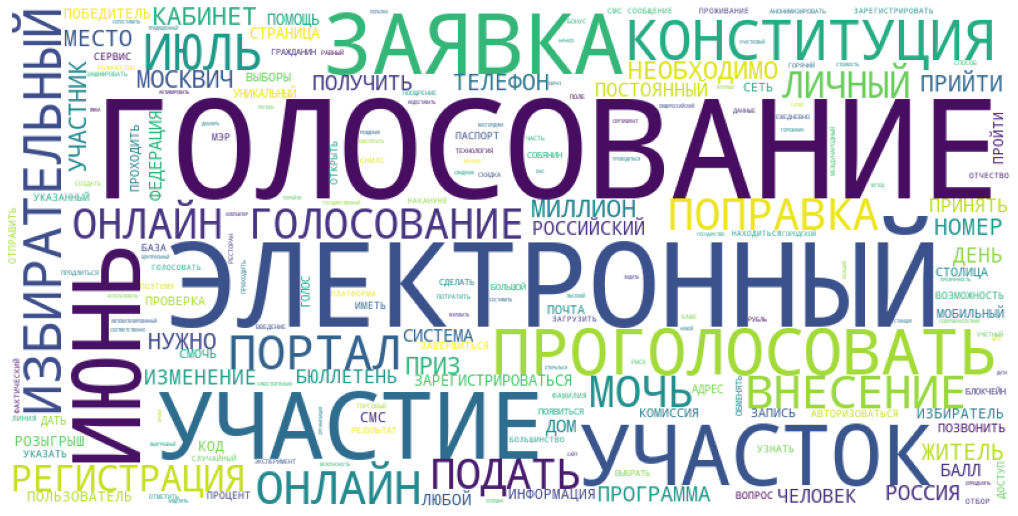

In [38]:
print(df_tags.loc[170217].title)
pic_profile(df_tags.loc[170217].words_text)

японские макаки


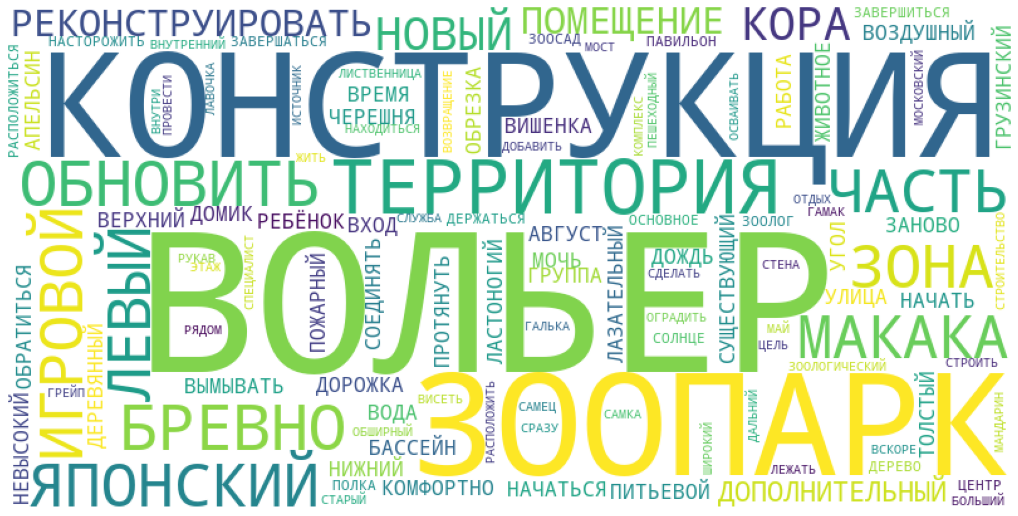

In [39]:
print(df_tags.loc[57138217].title)
pic_profile(df_tags.loc[57138217].words_text)

вакцина


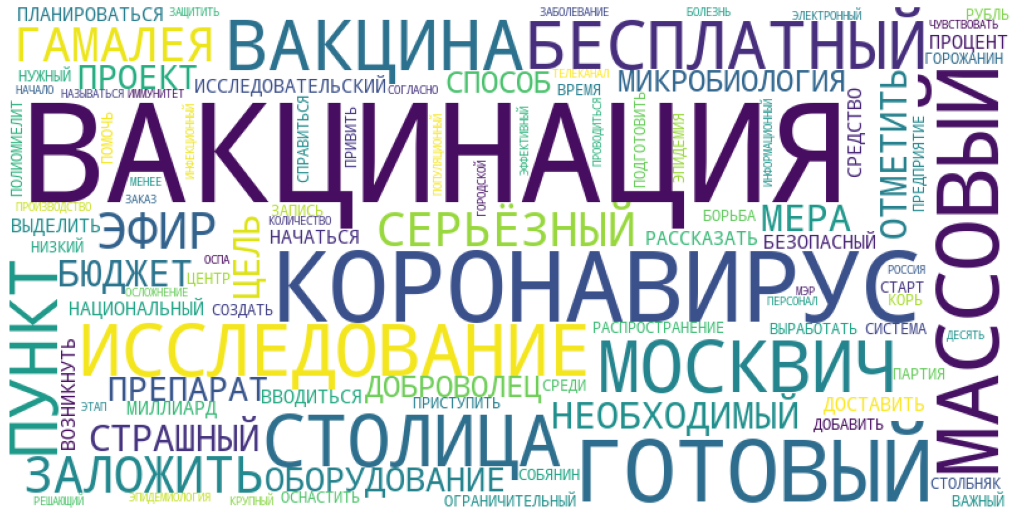

In [40]:
print(df_tags.loc[23373217].title)
pic_profile(df_tags.loc[23373217].words_text)

In [41]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax, title, words_text in zip(axs.flat, df_tags.title.iloc[:20], df_tags.words_text.iloc[:20]):
    ax.imshow(ava_profile(words_text))
    ax.axis("off")
    ax.set_title(title[:30]+('..' if len(title)>30 else ''))

plt.tight_layout()
plt.show()

# Тэги

In [42]:
df_news_organizations = df_news[['words_text', 'organization_ids']].explode('organization_ids')
df_organizations['words_text'] = pd.Series([
    list(chain.from_iterable(df_news_organizations.words_text[df_news_organizations.organization_ids==x])) 
    for x in df_organizations.index
], df_organizations.index)
df_organizations.head(10)

name  has_reception  \
id                                                                            
20614090   Департамент информационных технологий города М...              1   
9238090    Департамент предпринимательства и инновационно...              1   
19180090   Департамент градостроительной политики города ...              1   
19889090   Департамент жилищно-коммунального хозяйства го...              1   
12585090                  Департамент культуры города Москвы              1   
20488090      Департамент культурного наследия города Москвы              1   
103367090  Департамент инвестиционной и промышленной поли...              1   
20882090   Департамент транспорта и развития дорожно-тран...              1   
20703090   Департамент природопользования и охраны окружа...              1   
9479090            Департамент здравоохранения города Москвы              1   

              code short_name  lead_institution_id    qty  \
id                                                          
20614090       dit        ДИТ             11491090  319.0   
9238090       dpir       ДПИР             11491090  309.0   
19180090       dgp        ДГП             11491090  190.0   
19889090      dgkh       ДЖКХ             11491090  187.0   
12585090   kultura   Депкульт             11491090  186.0   
20488090       dkn        ДКН             11491090  159.0   
103367090     dipp       ДИПП             11491090  157.0   
20882090        dt   Дептранс             11491090  153.0   
20703090       eco     ДПиООС             11491090  146.0   
9479090     dzdrav   Депздрав             11491090  143.0   

                                                  words_text  
id                                                            
20614090   [ПРОГУЛКА, ИЗМАЙЛОВСКИЙ, БАБУШКИНСКИЙ, ПОЗНАВА...  
9238090    [ПРАВИТЕЛЬСТВО, УЧРЕДИТЬ, НОВЫЙ, ГРАНТ, ОБЩИЙ,...  
19180090   [ЮГО-ВОСТОК, РАЙОН, ЮЖНОПОРТОВЫЙ, СЧЁТ, СРЕДСТ...  
19889090   [ЗАВЕРШАТЬ, СЕЗОН, ВЫСАДКА, МНОГОЛЕТНИЙ, РАСТЕ...  
12585090   [ОНЛАЙН-ЗАЯВКА, ЗАЧИСЛЕНИЕ, КРУЖКА, СЕКЦИЯ, ПО...  
20488090   [КАНУН, ДЕНЬ, ВЛЮБИТЬ, СТОЛИЧНЫЙ, ДЕПАРТАМЕНТ,...  
103367090  [СТОЛИЦА, НАЧИНАТЬСЯ, ПЯТЫЙ, СЕЗОН, ПРОЕКТ, ОТ...  
20882090   [СЕНТЯБРЬ, ОКТЯБРЬ, ЗАКРЫТЬСЯ, УЧАСТОК, АРБАТС...  
20703090   [СПЕЦИАЛИСТ, МОСПРИРОДА, СООБЩАТЬ, СКОРО, ПРИР...  
9479090    [ГОРОДСКОЙ, КЛИНИЧЕСКИЙ, БОЛЬНИЦА, КОНЧАЛОВСКИ...

In [43]:
model = Tfidf_model(method='BM15', method_idf='smooth')
model.fit(df_organizations.words_text)

<ipython-input-30-a38e4130b54b>:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tfs = pd.concat([pd.Series(Counter(x)).div(len(x)) for x in corpus_BOW],


In [44]:
df_organizations[['name']].assign(score = model.predict(text)).nlargest(10, 'score')

name     score
id                                                                    
100297090  Государственное природоохранное бюджетное учре...  4.465652
100173090  Государственное бюджетное учреждение города Мо...  4.335641
100305090                                  ГУП «Мосгортранс»  3.970252
20882090   Департамент транспорта и развития дорожно-тран...  3.553694
20795090   Департамент средств массовой информации и рекл...  1.985786
19267090             Департамент строительства города Москвы  1.702489
19399090   Комитет по архитектуре и градостроительству го...  1.611432
103466090        Антитеррористическая комиссия города Москвы  1.327872
11491090                                Правительство Москвы  1.292867
19535090   Департамент развития новых территорий города М...  1.232689

In [45]:
df_organizations[['name']].loc[df_news.loc[80375073].organization_ids]

name
id                                                         
20882090  Департамент транспорта и развития дорожно-тран...

In [46]:
print('Организация', df_organizations.loc[20882090,'name'])
pic_profile(df_organizations.loc[20882090].words_text)

Организация Департамент транспорта и развития дорожно-транспортной инфраструктуры города Москвы


Организация Государственное бюджетное учреждение города Москвы "Информационно-аналитический центр Комплекса градостроительной политики и строительства города Москвы "Мосстройинформ"


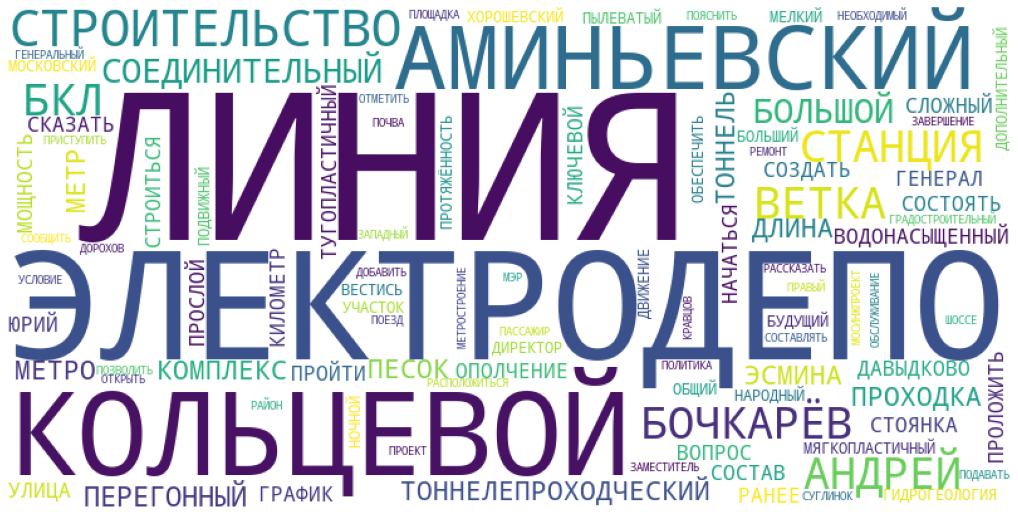

In [47]:
print('Организация', df_organizations.loc[100173090,'name'])
pic_profile(df_organizations.loc[100173090].words_text)

Новость Для пассажиров закрытого участка Арбатско-Покровской линии пустили бесплатные автобусы КМ


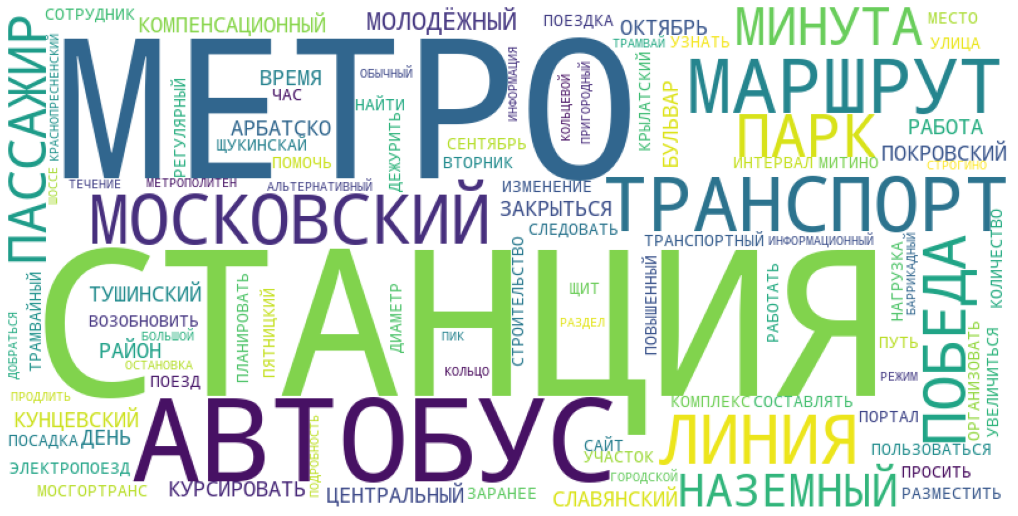

In [48]:
print('Новость', df_news.loc[80375073,'title'])
pic_profile(df_news.loc[80375073].words_text)

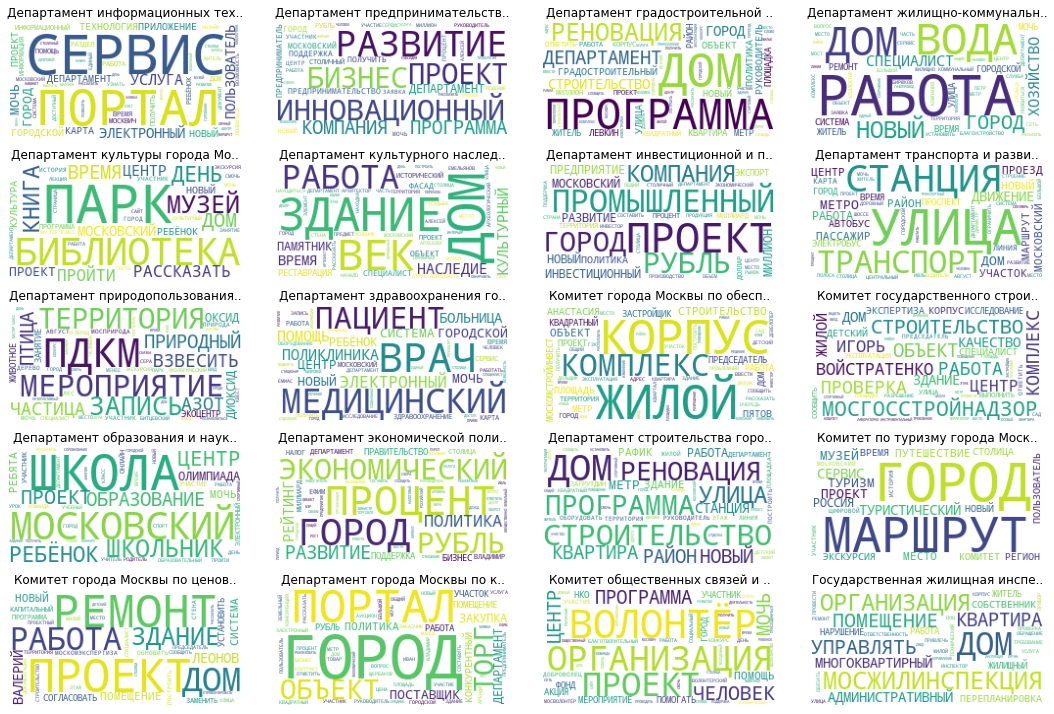

In [49]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax, title, words_text in zip(axs.flat, df_organizations.name.iloc[:20], df_organizations.words_text.iloc[:20]):
    ax.imshow(ava_profile(words_text))
    ax.axis("off")
    ax.set_title(title[:30]+('..' if len(title)>30 else ''))

plt.tight_layout()
plt.show()

# Организации

In [50]:
df_news_themes = df_news[['words_text', 'theme_ids']].explode('theme_ids')
df_themes['words_text'] = pd.Series([
    list(chain.from_iterable(df_news_themes.words_text[df_news_themes.theme_ids==x])) 
    for x in df_themes.index
], df_themes.index)
df_themes.head(10)

title           created_at  \
157287  Строительство и благоустройство  2019-11-06 11:08:33   
115287                Интересная Москва  2019-01-15 12:02:21   
27287                    Развитие метро  2017-11-03 22:23:24   
2287                 Планируйте маршрут  2017-11-03 22:23:24   
99287                  Музейные истории  2018-06-07 15:19:55   
213287            Здоровье и технологии  2021-05-19 12:06:26   
117287                Семейные выходные  2019-04-08 13:04:35   
116287              Советы библиотекаря  2019-03-18 12:23:01   
60287                       Люди города  2017-11-03 22:23:24   
210287                        Капремонт  2021-03-12 14:09:52   

                 updated_at  icon_id                      url  qty  \
157287  2021-07-02 17:43:19   4061.0  /news/maintheme/157287/  348   
115287  2021-07-06 20:04:25   8061.0  /news/maintheme/115287/  237   
27287   2021-07-02 17:47:10   3061.0   /news/maintheme/27287/   99   
2287    2021-07-07 10:17:22      NaN    /news/maintheme/2287/   80   
99287   2021-07-06 20:04:25   5061.0   /news/maintheme/99287/   77   
213287  2021-07-02 17:49:57  19061.0  /news/maintheme/213287/   63   
117287  2021-07-02 16:09:06  11061.0  /news/maintheme/117287/   48   
116287  2021-07-02 16:09:06      NaN  /news/maintheme/116287/   43   
60287   2021-04-08 20:36:38      NaN   /news/maintheme/60287/   39   
210287  2021-06-18 18:29:01      NaN  /news/maintheme/210287/   37   

                                               words_text  
157287  [МИТИН, ВВЕСТИ, ЭКСПЛУАТАЦИЯ, СПОРТИВНЫЙ, КОМП...  
115287  [НОЯБРЬ, ОТКРЫТЬСЯ, СТРАНА, МИР, ПЛАНЕТАРИЙ, С...  
27287   [ПРОДЛЕНИЕ, ТРОИЦКИЙ, ЛИНИЯ, МЕТРО, СТАНЦИЯ, С...  
2287    [РАСПИСАНИЕ, ПРИГОРОДНЫЙ, ПОЕЗД, САВЁЛОВСКИЙ, ...  
99287   [НОВЫЙ, ВЫПУСК, ИСТОРИЯ, ВЕЩЬ, РАССКАЗАТЬ, ПУТ...  
213287  [МОСКОВСКИЙ, ПОЛИКЛИНИКА, БОЛЬШОЙ, СТАНОВИТЬСЯ...  
117287  [ВЫХОДНОЙ, СОТРУДНИК, МОСКОВСКИЙ, БИБЛИОТЕКА, ...  
116287  [ВЫХОДНОЙ, СОТРУДНИК, МОСКОВСКИЙ, БИБЛИОТЕКА, ...  
60287   [НОЯБРЬ, ОТКРЫТЬСЯ, СТРАНА, МИР, ПЛАНЕТАРИЙ, С...  
210287  [ВДНХ, ОТРЕМОНТИРОВАТЬ, СКЛАДСКОЙ, ПОМЕЩЕНИЕ, ...

In [51]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax, title, words_text in zip(axs.flat, df_themes.title.iloc[:20], df_themes.words_text.iloc[:20]):
    ax.imshow(ava_profile(words_text))
    ax.axis("off")
    ax.set_title(title[:30]+('..' if len(title)>30 else ''))

plt.tight_layout()
plt.show()

# Темы

In [52]:
df_news_spheres = df_news[['words_text', 'sphere_ids']].explode('sphere_ids')
df_spheres['words_text'] = pd.Series([
    list(chain.from_iterable(df_news_spheres.words_text[df_news_spheres.sphere_ids==x])) 
    for x in df_spheres.index
], df_spheres.index)
df_spheres.head(10)

title  special  activated  priority   qty  \
231299                        Мой район        0          1       410  1416   
4299      Строительство и реконструкция        0          1       490  1095   
3299                           Культура        0          1       360   986   
12299   Экономика и предпринимательство        0          1       370   847   
1299                   Социальная сфера        0          1       400   717   
5299                Городское хозяйство        0          1       460   651   
18299                   Здравоохранение        0          1       500   606   
183299                       Технологии        0          1       440   602   
2299                          Транспорт        0          1       480   593   
15299                       Образование        0          1       470   455   

                                               words_text  
231299  [СЕНТЯБРЬ, ОКТЯБРЬ, ЗАКРЫТЬСЯ, УЧАСТОК, АРБАТС...  
4299    [ЮГО-ВОСТОК, РАЙОН, ЮЖНОПОРТОВЫЙ, СЧЁТ, СРЕДСТ...  
3299    [НОЯБРЬ, ОТКРЫТЬСЯ, СТРАНА, МИР, ПЛАНЕТАРИЙ, С...  
12299   [ПРАВИТЕЛЬСТВО, УЧРЕДИТЬ, НОВЫЙ, ГРАНТ, ОБЩИЙ,...  
1299    [ПОРТАЛ, ОТКРЫТЬСЯ, ЗАПИСЬ, УЧАСТИЕ, ОНЛАЙН-ГО...  
5299    [ЗАВЕРШАТЬ, СЕЗОН, ВЫСАДКА, МНОГОЛЕТНИЙ, РАСТЕ...  
18299   [ГОРОДСКОЙ, КЛИНИЧЕСКИЙ, БОЛЬНИЦА, КОНЧАЛОВСКИ...  
183299  [ГОРОДСКОЙ, КЛИНИЧЕСКИЙ, БОЛЬНИЦА, КОНЧАЛОВСКИ...  
2299    [СЕНТЯБРЬ, ОКТЯБРЬ, ЗАКРЫТЬСЯ, УЧАСТОК, АРБАТС...  
15299   [ОНЛАЙН-ЗАЯВКА, ЗАЧИСЛЕНИЕ, КРУЖКА, СЕКЦИЯ, ПО...

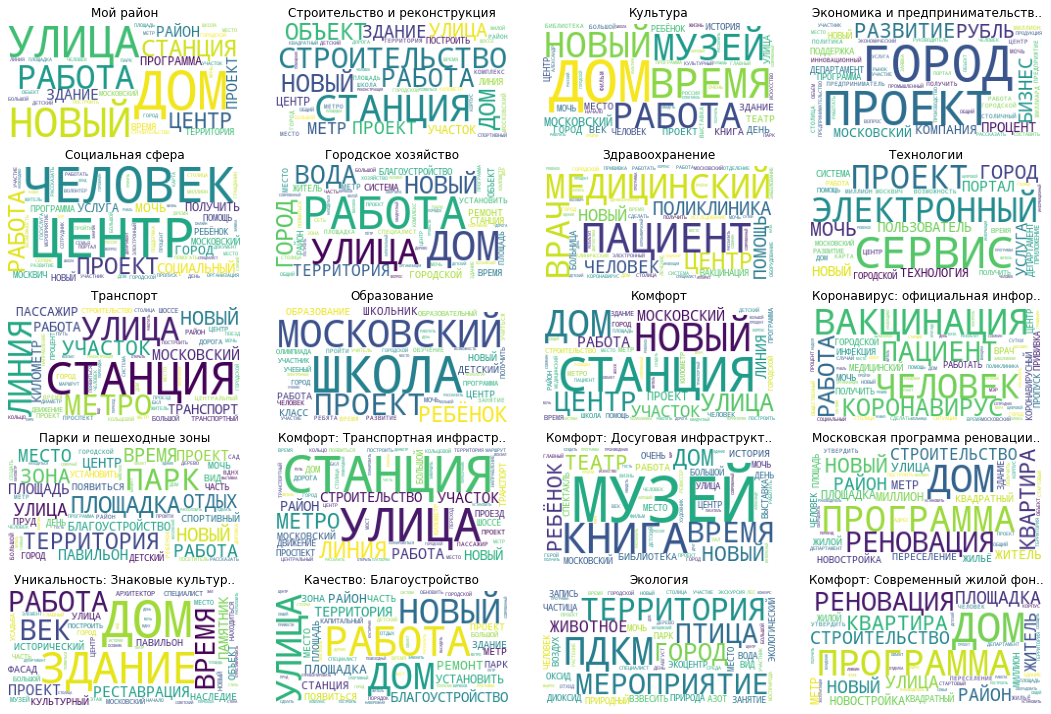

In [53]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax, title, words_text in zip(axs.flat, df_spheres.title.iloc[:20], df_spheres.words_text.iloc[:20]):
    ax.imshow(ava_profile(words_text))
    ax.axis("off")
    ax.set_title(title[:30]+('..' if len(title)>30 else ''))

plt.tight_layout()
plt.show()

# Сферы

In [54]:
df_areas['words_text'] = pd.Series([
    list(chain.from_iterable(df_news.words_text[df_news.territory_area_id==x])) 
    for x in df_areas.index
], df_areas.index)
df_areas.head(10)

district_id district_title      area_title  \
area_id                                               
1501            1500    Центральный           Арбат   
2501            1500    Центральный       Басманный   
3501            1500    Центральный   Замоскворечье   
4501            1500    Центральный  Красносельский   
5501            1500    Центральный       Мещанский   
6501            1500    Центральный     Пресненский   
7501            1500    Центральный       Таганский   
8501            1500    Центральный        Тверской   
9501            1500    Центральный       Хамовники   
10501           1500    Центральный        Якиманка   

                                                words_text  
area_id                                                     
1501     [НАСЛАДИТЬСЯ, РОМАНС, НИКОЛАЙ, РИМСКИЙ-КОРСАКО...  
2501     [СТОЛИЧНЫЙ, БИБЛИОТЕКА, ПОДГОТОВИТЬ, ПРАЗДНИЧН...  
3501     [КАНУН, ДЕНЬ, ВЛЮБИТЬ, СТОЛИЧНЫЙ, ДЕПАРТАМЕНТ,...  
4501     [МЕДИАПЛАТФОРМА, МОСКВАСТОБОЙ, ЦИФРОВОЙ, ТУРИС...  
5501     [СЕРЕДИНА, ИЮНЬ, ГОРОД, УКРАСИТЬ, МИЛЛИОН, ОДН...  
6501     [НОЯБРЬ, ОТКРЫТЬСЯ, СТРАНА, МИР, ПЛАНЕТАРИЙ, С...  
7501     [АРЕНДОВАТЬ, САМОКАТ, ВЕЛОСИПЕД, СКИДКА, ПОДВЕ...  
8501     [НАЗВАТЬ, ПОБЕДИТЕЛЬ, ЕЖЕГОДНЫЙ, КОНКУРС, ХОРО...  
9501     [НОВЫЙ, ВЫПУСК, ИСТОРИЯ, ВЕЩЬ, РАССКАЗАТЬ, ПУТ...  
10501    [ГРАДОСТРОИТЕЛЬНО-ЗЕМЕЛЬНЫЙ, КОМИССИЯ, ГОРОД, ...

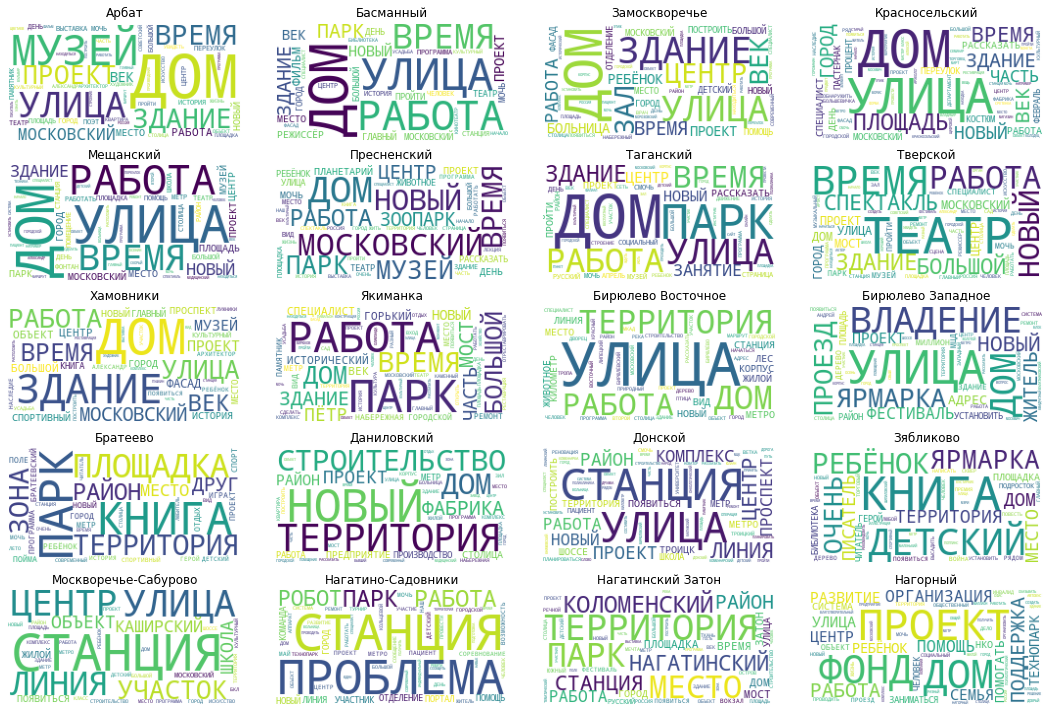

In [55]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax, title, words_text in zip(axs.flat, df_areas.area_title.iloc[:20], df_areas.words_text.iloc[:20]):
    ax.imshow(ava_profile(words_text))
    ax.axis("off")
    ax.set_title(title[:30]+('..' if len(title)>30 else ''))

plt.tight_layout()
plt.show()

# Городские районы

In [56]:
# Протестируем работу NER-алгоритма на это новости'

txt = bt(df_news.loc[49617073,'full_text'])
print('Новость', df_news.loc[49617073,'title'], '\n\n', txt)

Новость Где лучшие химики, физики и математики: названы победители олимпиады «Учитель школы большого города» 

 27 декабря Департамент образования и науки подвел итоги первой олимпиады «Учитель школы большого города». В профессиональных соревнованиях участвовали более двух тысяч преподавателей математики, физики и химии. Педагоги прошли четыре конкурсных этапа — дистанционный, очный, практический и финальный. По словам самих участников, больше всего им понравился лабораторный практикум, на котором нужно было ставить опыты и экспериментировать.
Главная цель олимпиады «Учитель школы большого города» — поддержка и поощрение педагогов, которые обладают глубокими знаниями по своему предмету.
Как прошел финал олимпиады 
В финал олимпиады прошли 19 участников. 21 декабря в Московском центре технологической модернизации образования они  выступили перед коллегами с авторскими мастер-классами. 
По итогам олимпиады определились семь победителей. Лучшими преподавателями химии стали Владимир Головн

In [57]:
# NER можно применять, работает. Как дополнение к другим инструме6нтам - хорошо.
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    Doc
)

emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
ner_tagger = NewsNERTagger(emb)
 
doc = Doc(txt)
doc.segment(segmenter)
doc.tag_ner(ner_tagger)
 
for span in doc.spans:
    span.normalize(morph_vocab)

NER_extract = dict(pd.DataFrame([(x.type, x.normal) for x in doc.spans], columns=['type', 'title']).groupby('type').title.unique())

if 'ORG' in NER_extract:
    print('Найдены организации: ', ', '.join(NER_extract['ORG']))
if 'LOC' in NER_extract:
    print('\nНайдены места: ', ', '.join(NER_extract['LOC']))
if 'PER' in NER_extract:
    print('\nНайдены люди: ', ', '.join(NER_extract['PER']))

Найдены организации:  Департамент образования и науки, Московском центре

Найдены люди:  Владимир Головнер, Евгений Трубицын, Дмитрий Невидимый, Игорь Эльман, Дмитрий Мухин, Филипп Шапошников, Варвара Копьева


In [58]:
# Посмотрел датасеты в открытых данных
# Датасеты в открытых данных не обновялись уже давно, решилb не использовать
json_datasets = json.loads((DATA_DIR/'datasets.json').read_text(encoding='utf-8'))
df_datasets = pd.DataFrame(
    ((item['Id'], item['Caption'], item['LastUpdateDate'], item['IsArchive']) for item in json_datasets['Items']), 
    columns=['Id', 'Caption', 'LastUpdateDate', 'IsArchive']
).set_index('Id').rename_axis(None)
df_datasets.LastUpdateDate = pd.to_datetime(df_datasets.LastUpdateDate)
df_datasets[~df_datasets.IsArchive].sort_values('LastUpdateDate', ascending=False).head(40)

Caption LastUpdateDate  \
62381  График закрытия акушерских стационаров медицин...     2021-11-01   
1461   Перечень приватизируемых объектов в разрезе эт...     2021-10-25   
62701  Ежемесячный рейтинг станций Московского метроп...     2021-09-23   
2682                        Мобильные прививочные пункты     2021-09-20   
62662          Выделенные полосы на улично-дорожной сети     2021-09-16   
62681                                     Дорожные знаки     2021-09-09   
62101          Запланированные дорожные ремонтные работы     2021-07-28   
62603  Карта улиц с односторонним движением в городе ...     2021-07-22   
62601  Карта улиц с уменьшенной скоростью движения «Б...     2021-07-22   
62059        Светофорные объекты на улично-дорожной сети     2021-07-22   
62581  Работы по капитальному ремонту и благоустройст...     2021-07-20   
62207  Входы и выходы станций Московских центральных ...     2021-07-14   
62201                     Железнодорожные вокзалы Москвы     2021-07-14   
62441  Текущие (локальные) ремонтные работы, проводим...     2021-06-04   
918                          Станции проката велосипедов     2021-06-04   
62421  Московский реестр участников и неучастников бю...     2021-06-03   
62541                 Карта «школьных зон» города Москвы     2021-05-24   
62525  Карта среднемесячной загруженности дорог с инд...     2021-05-13   
62523  Годовой пассажиропоток по всем видам обществен...     2021-05-13   
62521  Месячный пассажиропоток по всем видам обществе...     2021-05-13   
62747  Табло отображения информации на улично-дорожно...     2021-05-10   
62745  Точность выполнения расписания на линиях Моско...     2021-05-10   
62743  Пассажиропоток по станциям Московского метропо...     2021-05-10   
62741  Информация о количестве станций, вагонов и про...     2021-05-10   
744                         Приюты для бродячих животных     2021-05-05   
2317   Перечень дорожных специализированных предприят...     2021-05-04   
62503  Реабилитационные и Реабилитационно-образовател...     2021-04-30   
62501  Данные о действующих зарегистрированных уведом...     2021-04-29   
916                                Велосипедные парковки     2021-04-27   
2855   Данные о действующих ордерах на производство р...     2021-04-27   
62481      Туристский событийный календарь города Москвы     2021-04-23   
3295   Мероприятия по установке подъемных платформ дл...     2021-04-06   
1343   Справочник органов исполнительной власти город...     2021-03-26   
897                                 Дорожки велосипедные     2021-03-25   
1046   Ответственные балансодержатели межрельсового п...     2021-03-25   
624    Входы и выходы вестибюлей станций Московского ...     2021-03-09   
1982   Динамика изменения величины прожиточного миним...     2021-02-09   
62461  Данные о действующих зарегистрированных уведом...     2021-02-08   
620                                Ярмарки выходного дня     2021-02-04   
62409  Ежегодное количество культурных мероприятий в ...     2021-01-21   

       IsArchive  
62381      False  
1461       False  
62701      False  
2682       False  
62662      False  
62681      False  
62101      False  
62603      False  
62601      False  
62059      False  
62581      False  
62207      False  
62201      False  
62441      False  
918        False  
62421      False  
62541      False  
62525      False  
62523      False  
62521      False  
62747      False  
62745      False  
62743      False  
62741      False  
744        False  
2317       False  
62503      False  
62501      False  
916        False  
2855       False  
62481      False  
3295       False  
1343       False  
897        False  
1046       False  
624        False  
1982       False  
62461      False  
620        False  
62409      False